In [1]:
!pip install pytorch-ignite -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 19.5 MB/s eta 0:00:00


In [2]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
import ignite.metrics
import ignite.contrib.handlers


In [3]:
DATA_DIR='./data' # データ保存用のディレクトリ

IMAGE_SIZE = 32 # 入力画像1辺のサイズ
NUM_CLASSES = 100 # 分類するクラスの数
NUM_WORKERS = 10 # データローダーが使用するサブプロセスの数を指定
BATCH_SIZE = 32 # ミニバッチのサイズ
LEARNING_RATE = 1e-3 # 最大学習率
WEIGHT_DECAY = 1e-1 # オプティマイザーの重み減衰率
EPOCHS = 150 # 学習回数


In [4]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)


device: cuda


In [5]:
# トレーニングデータに適用する一連の変換操作をtransforms.Composeにまとめる
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # ランダムに左右反転
    # 4ピクセルのパディングを挿入してランダムに切り抜く
    transforms.RandomCrop(IMAGE_SIZE, padding=4),
    # 画像のコントラスト、彩度、色相をランダムに変化させる
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor() # テンソルに変換
])


In [6]:
# CIFAR-100データセットのトレーニングデータを読み込み、データ拡張を適用
train_dset = datasets.CIFAR100(
    root=DATA_DIR, train=True, download=True, transform=train_transform)
# CIFAR-100データセットのテストデータを読み込んでテンソルに変換する処理のみを行う
test_dset = datasets.CIFAR100(
    root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())


100%|██████████| 169001437/169001437 [00:12<00:00, 13249042.15it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
# トレーニング用のデータローダーを作成
train_loader = torch.utils.data.DataLoader(
    train_dset,
    batch_size=BATCH_SIZE,
    shuffle=True, # 抽出時にシャッフルする
    num_workers=NUM_WORKERS, # データ抽出時のサブプロセスの数を指定
    pin_memory=True # データを固定メモリにロード
    )

# テスト用のデータローダーを作成
test_loader = torch.utils.data.DataLoader(
    test_dset,
    batch_size=BATCH_SIZE,
    shuffle=False, # 抽出時にシャッフルしない
    num_workers=NUM_WORKERS, # データ抽出時のサブプロセスの数を指定
    pin_memory=True # データを固定メモリにロード
    )


In [8]:
class LayerNormChannels(nn.Module):
    """ チャンネル方向にLayer Normalizationを適用するモジュール
    Attributes:
        norm (nn.LayerNorm): チャンネル方向にLayer Normalizationを適用するためのレイヤー
    """
    def __init__(self, channels):
        """
        Args:
            channels (int): 正規化レイヤーを適用するチャンネル数
        """
        super().__init__()
        # 指定されたチャンネル数に基づいてLayer Normalizationレイヤーを作成
        self.norm = nn.LayerNorm(channels)

    def forward(self, x):
        """ フォワードパス

        Args:
            x (Tensor): 入力特徴マップ
                形状は (bs, チャンネル次元, 特徴高さ, 特徴幅)

        Returns:
            Tensor: チャンネル方向にLayer Normalizationを適用した後のテンソル
                    形状は入力時と同じ
        """
        # テンソルのチャンネル次元を最後の次元に配置する
        x = x.transpose(1, -1)
        # チャンネル次元 にLayerNormalizationを適用
        x = self.norm(x)
        # チャンネル次元を元の位置に戻す
        x = x.transpose(-1, 1)
        return x


In [9]:
class Residual(nn.Module):
    """ 残差接続を実装するモジュール
    Attributes:
        shortcut(nn.Module): ショートカット接続を適用するレイヤー
        residual(nn.Sequential): 残差接続のためのレイヤー群をまとめたnn.Sequential
        gamma(nn.Parameter): 残差接続のスケーリング係数にする学習可能なパラメーター
    """
    def __init__(self, *layers, shortcut=None):
        """
        Args:
            layers(tuple of nn.Module): 残差接続を設定するレイヤー群
            shortcut (nn.Module): ショートカット接続に使用するレイヤー
        """
        super().__init__()
        # ショートカット接続のレイヤーを設定
        if shortcut is None:
            # shortcutがNoneの場合は入力をそのまま出力するIdentityレイヤーを設定
            self.shortcut = nn.Identity()
        else:
            # shortcutが指定されている場合はself.shortcutにセット
            self.shortcut = shortcut

        # 残差接続として使用するレイヤー群を nn.Sequentialでまとめる
        self.residual = nn.Sequential(*layers)
        # 残差接続のスケーリングパラメータgammaをゼロで初期化
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        """ フォワードパス
        Args:
            x (Tensor): 入力テンソル。

        Returns:
            Tensor: ショートカット接続とスケーリングされた残差接続の和
        """
        return self.shortcut(x) + self.gamma * self.residual(x)


In [10]:
class SelfAttention2d(nn.Module):
    """ 2D入力に対して自己注意機構を適用するモジュール
    Attributes:
        heads (int): ヘッドの数
        head_channels (int): 各ヘッドの次元数(チャンネル数)
        scale (float): クエリとキーの内積をスケーリングするための係数
        stride_q (int): クエリに対するストライド
        pool_q (nn.Module): クエリに対するプーリングレイヤーまたはIdentityレイヤー
        pool_k (nn.Module): キーに対するプーリングレイヤーまたはIdentityレイヤー
        pool_v (nn.Module): バリューに対するプーリングレイヤーまたはIdentityレイヤー
        to_keys (nn.Conv2d): 入力からキーを生成するための畳み込み層
        to_queries (nn.Conv2d): 入力からクエリを生成するための畳み込み層
        to_values (nn.Conv2d): 入力からバリューを生成するための畳み込み層
        unifyheads (nn.Conv2d):
            全てのヘッドの出力を統合して元のチャンネル数に戻すための畳み込み層
        drop (nn.Dropout): 出力に対して適用されるドロップアウト層。
    """
    def __init__(self, channels, head_channels, heads=1,
                 kernel_q=1, stride_q=1, kernel_kv=1, stride_kv=1, p_drop=0.):
        """
        Args:
            channels (int): 入力テンソルのチャンネル数
            head_channels (int): 各ヘッドの次元数(チャンネル数)
            heads (int): ヘッドの数。デフォルトは1
            kernel_q (int): クエリに対するカーネルサイズ。デフォルトは1
            stride_q (int): クエリに対するストライド。デフォルトは1
            kernel_kv (int): キーとバリューに対するカーネルサイズ。デフォルトは1
            stride_kv (int): キーとバリューに対するストライド。デフォルトは1
            p_drop (float): ドロップアウト率。デフォルトは0.0
        """
        super().__init__()

        # 内部チャンネル数を計算(ヘッド数とヘッドチャンネル数の積)
        inner_channels = head_channels * heads

        # ヘッド数とヘッドの次元数(チャンネル数)を設定
        self.heads = heads
        self.head_channels = head_channels
        # スケーリング係数を計算(ヘッドチャンネル数の平方根の逆数)
        self.scale = head_channels**-0.5
        # クエリに対するストライドを設定
        self.stride_q = stride_q

        # クエリとキー/バリューのパディングサイズを計算
        padding_q = kernel_q // 2
        padding_kv = kernel_kv // 2

        # クエリのプーリングレイヤーを設定する
        if kernel_q > 1:
            # クエリのカーネルサイズが1より大きい場合はpadding_qのパディングを行う
            self.pool_q = nn.MaxPool2d(kernel_q, stride_q, padding_q)
        else:
            # それ以外は入力をそのまま出力するIdentityレイヤーを設定
            self.pool_q = nn.Identity()

        # キーのプーリングレイヤーを設定する
        if kernel_kv > 1:
            # キーのカーネルサイズが1より大きい場合はpadding_kvのパディングを行う
            self.pool_k = nn.MaxPool2d(kernel_kv, stride_kv, padding_kv)
        else:
            # それ以外は入力をそのまま出力するIdentityレイヤーを設定
            self.pool_k = nn.Identity()

        # バリューのプーリングレイヤーを設定する
        if kernel_kv > 1:
            # バリューのカーネルサイズが1より大きい場合はpadding_kvのパディングを行う
            self.pool_v = nn.MaxPool2d(kernel_kv, stride_kv, padding_kv)
        else:
            # それ以外は入力をそのまま出力するIdentityレイヤーを設定
            self.pool_v = nn.Identity()

        # キー、クエリ、バリューを生成するための畳み込み層を生成
        self.to_keys = nn.Conv2d(channels, inner_channels, 1)
        self.to_queries = nn.Conv2d(channels, inner_channels, 1)
        self.to_values = nn.Conv2d(channels, inner_channels, 1)
        # 全てのヘッドの出力を統合するための畳み込み層を生成
        self.unifyheads = nn.Conv2d(inner_channels, channels, 1)
        # ドロップアウトを生成
        self.drop = nn.Dropout(p_drop)

    def forward(self, x):
        """ フォワードパス
        Args:
            x (Tensor): 入力特徴マップ
                形状は (bs, チャンネル次元, 特徴高さ, 特徴幅)

        Returns:
            Tensor: 自己注意機構を適用後の特徴マップ
                    形状は入力時と同じ
        """
        # 入力特徴マップのバッチサイズ、特徴高さ、特徴幅を取得
        b, _, h, w = x.shape

        # キーを生成し、プーリングを適用
        # 形状を(bs, ヘッド数, ヘッドの次元数, チャンネル次元数)に変換
        keys = self.to_keys(x)
        keys = self.pool_k(keys)
        keys = keys.view(b, self.heads, self.head_channels, -1)

        # クエリを生成し、プーリングを適用
        # 形状を(bs, ヘッド数, ヘッドの次元数, チャンネル次元数)に変換
        queries = self.to_queries(x)
        queries = self.pool_q(queries)
        queries = queries.view(b, self.heads, self.head_channels, -1)

        # バリューを生成し、プーリングを適用
        # 形状を(bs, ヘッド数, ヘッドの次元数, チャンネル次元数)に変換
        values = self.to_values(x)
        values = self.pool_v(values)
        values = values.view(b, self.heads, self.head_channels, -1)

        # キーのヘッド次元とチャンネル次元を転置し、クエリとの行列積を計算
        att = keys.transpose(-2, -1) @ queries
        # スケーリングを適用してソフトマックスで正規化する
        att = F.softmax(att * self.scale, dim=-2)

        # 正規化されたアテンションスコアをバリューに適用し、重み付けを行う
        out = values @ att
        # outテンソルの形状を以下に変更
        # (bs, -1, 入力特徴高さ//self.stride_q, 入力特徴幅//self.stride_q)
        # -1は自動計算されるため、全てのヘッドのチャンネル次元数が結合された状態になる
        out = out.view(b, -1, h // self.stride_q, w //self.stride_q)
        # ヘッドからの出力を畳み込み層で統合し、元のチャンネル次元数に戻す
        out = self.unifyheads(out)
        # ドロップアウトを適用
        out = self.drop(out)
        return out


In [11]:
class FeedForward(nn.Sequential):
    """ 畳み込み層を使用したフィードフォワードネットワークを構築

    """
    def __init__(self, in_channels, out_channels, mult=4, p_drop=0.):
        """
        Args:
            in_channels (int): 入力のチャンネル数
            out_channels (int): 出力のチャンネル数
            mult (int): 隠れ層のチャンネル数を決定するための倍率
                        デフォルトは4
            p_drop (float): ドロップアウト率
        """
        # 入力チャンネル数に倍率を掛けて隠れ層のチャンネル数を決定
        hidden_channels = in_channels * mult

        # nn.Sequentialのコンストラクターにレイヤーを生成して渡す
        super().__init__(
            # 1x1の畳み込み層を用いて、入力チャンネルを隠れ層のチャンネル数に拡張
            nn.Conv2d(in_channels, hidden_channels, 1),
            # GELU活性化関数
            nn.GELU(),
            # 1x1の畳み込み層を用いて、隠れ層のチャンネル数を出力チャンネル数に縮小
            nn.Conv2d(hidden_channels, out_channels, 1),
            # ドロップアウトを適用
            nn.Dropout(p_drop)
        )


In [12]:
class TransformerBlock(nn.Sequential):
    """ 自己注意機構を内部に配置したTransformerブロックを構築する

    """
    def __init__(self, in_channels, out_channels, head_channels, heads=1,
                 kernel_q=1, stride_q=1, kernel_kv=1, stride_kv=1, p_drop=0.):
        """
        Args:
            in_channels (int): 入力のチャンネル数
            out_channels (int): 出力のチャンネル数
            head_channels (int): 各ヘッドのチャンネル数
            heads (int): ヘッドの数
            kernel_q (int): クエリに使用するカーネルサイズ
            stride_q (int): クエリに使用するストライド
            kernel_kv (int): キーとバリューに使用するカーネルサイズ
            stride_kv (int): キーとバリューに使用するストライド
            p_drop (float): ドロップアウト率
        """
        # クエリに使用するカーネルサイズに基づいてパディングサイズを計算
        padding_q = kernel_q // 2

        # ResidualブロックにSelfAttention2dを組み込み、残差接続を行う
        layers = [
            Residual(
                # チャンネル方向に正規化を適用するLayerNormChannelsを配置
                LayerNormChannels(in_channels),
                # SelfAttention2dを配置
                SelfAttention2d(
                    in_channels,  # 入力のチャンネル数
                    head_channels,  # 各ヘッドのチャンネル次元数
                    heads,  # ヘッドの数
                    kernel_q,  # クエリに使用するカーネルサイズ
                    stride_q,  # クエリに使用するストライド
                    kernel_kv,  # キーとバリューに使用するカーネルサイズ
                    stride_kv,  # キーとバリューに使用するストライド
                    p_drop  # ドロップアウト率
                ),
                # ショートカットとしてプーリング層(MaxPool2d)またはIdentity層を選択
                shortcut=(
                    # kernel_qが1より大きい場合はプーリング層を選択
                    # それ以外はIdentity層を選択
                    nn.MaxPool2d(kernel_q, stride_q, padding_q)
                    if kernel_q > 1
                    else nn.Identity()
                )
            )
        ]

        # 入力チャンネル数と出力チャンネル数が同じ場合
        if in_channels == out_channels:
            # 残差接続を行うResidualブロックを配置
            # (内部にLayerNormChannels、FeedForwardを配置)
            layers.append(
                Residual(
                    LayerNormChannels(in_channels),
                    FeedForward(in_channels, out_channels, p_drop=p_drop)
                )
            )
        # 入力チャンネル数と出力チャンネル数が異なる場合
        else:
            # LayerNormChannelsを配置
            # ショートカットにチャンネル数を変換するための1x1畳み込み層を指定し、
            # 残差接続を行うResidualブロックを配置(内部にFeedForwardを配置)
            layers += [
                LayerNormChannels(in_channels),
                Residual(
                    FeedForward(in_channels, out_channels, p_drop=p_drop),
                     # チャンネル数を変換するための1x1畳み込み層をショートカットに設定
                    shortcut=nn.Conv2d(in_channels, out_channels, 1)
                )
            ]

        # nn.Sequentialのコンストラクターにレイヤー群を渡す
        super().__init__(*layers)


In [13]:
class TransformerStack(nn.Sequential):
    """ 複数のTransformerBlockを積み重ねる

    """
    def __init__(self,
                 in_channels, head_channels,
                 repetitions, strides, stride_kv, p_drop=0.):
        """
        Args:
            in_channels (int): 入力のチャンネル数
            head_channels (int): 各ヘッドのチャンネル数
            repetitions (list of int): 各ストライドに対してTransformerBlockを
                                       繰り返す回数のリスト
            strides (list of int): 各ステージで使用するストライドのるリスト
            stride_kv (int): キーとバリュー生成時に適用するストライド
            p_drop (float): ドロップアウト率
        """
        # レイヤーを格納するリスト
        layers = []
        # 現在の出力チャンネル数を入力チャンネル数に設定
        out_channels = in_channels
        # 最初のヘッド数を1に設定
        heads = 1

        # repetitionsとstridesのリストを同時にループする
        for rep, stride_q in zip(repetitions, strides):
            # クエリ用のカーネルサイズを設定
            kernel_q = stride_q + 1 if stride_q > 1 else 1
            # キーとバリューに使用するストライドをクエリのストライドで割って更新
            stride_kv = stride_kv // stride_q
            # キーとバリュー用のカーネルサイズを設定
            kernel_kv = stride_kv + 1 if stride_kv > 1 else 1
            # ヘッド数をストライドに基づいて更新
            heads *= stride_q

            # repetitionsで指定された数に従ってTransformerBlockを配置
            for _ in range(rep):
                # TransformerBlockを追加
                layers.append(
                    TransformerBlock(
                        in_channels,
                        out_channels,
                        head_channels,
                        heads,
                        kernel_q, stride_q,
                        kernel_kv,
                        stride_kv,
                        p_drop
                        )
                    )
                # 次のブロックの入力チャンネル数を現在の出力チャンネル数に更新
                in_channels = out_channels
                # 次のブロックではクエリのストライドとカーネルサイズを1にリセット
                stride_q = 1
                kernel_q = 1

            # 次のステージで使用するために出力チャンネル数を2倍に増やす
            out_channels *= 2

        # nn.Sequentialのコンストラクターにレイヤー群を渡す
        super().__init__(*layers)


In [14]:
class PatchEmbedding(nn.Module):
    """ 画像をパッチに分割し、それらのパッチを埋め込み表現に変換するモジュール

    """
    def __init__(self, in_channels, out_channels, patch_size, stride, padding):
        """
        Args:
            in_channels (int): 入力画像のチャンネル数
            out_channels (int): 出力されるパッチの埋め込み次元数
            patch_size (int): パッチのサイズ（畳み込みカーネルのサイズとして使用）
            stride (int): 畳み込みのストライド
            padding (int): 畳み込みのパディング
        """
        super().__init__()
        # 入力画像をパッチに分割し、埋め込み表現に変換するための2D畳み込み層を生成
        self.conv = nn.Conv2d(
            in_channels,       # 入力チャンネル数
            out_channels,      # 出力チャンネル数(埋め込み次元数)
            patch_size,        # パッチのサイズ(カーネルサイズ)
            stride=stride,     # ストライド
            padding=padding    # パディング
        )

    def forward(self, x):
        """ フォワードパス

        Args:
            x (Tensor): 入力画像テンソル
                        形状: (bs, チャンネル次元数, 画像高さ, 画像幅)
        Returns:
            torch.Tensor:
                埋め込み表現が適用されたパッチ分割後のテンソル
                形状:(bs, out_channels, パッチ分割後の特徴高さ, パッチ分割後の特徴幅)
                パディング処理により、特徴高さ、特徴幅は入力時と同じ
        """
        # 畳み込み層を適用して、入力画像をパッチ埋め込み表現に変換
        x = self.conv(x)
        return x


In [15]:
class PositionEmbedding(nn.Module):
    """ 入力テンソルに位置情報を追加するモジュール

    """
    def __init__(self, channels, image_size):
        """
        Args:
            channels (int): 入力テンソルのチャンネル数
            image_size (int): 入力画像1辺のサイズ
        """
        super().__init__()
        # 位置情報を学習する学習可能なパラメーターを生成
        # 形状は (1, チャンネル数, 特徴高さ, 特徴幅)
        self.pos_embedding = nn.Parameter(
            torch.zeros(
                1,  # バッチサイズの次元数
                channels,  # チャンネル数
                image_size,  # image_sizeを特徴高さに設定
                image_size   # image_sizeを特徴幅に設定
                )
            )

    def forward(self, x):
        """ フォワードパス
        Args:
            x (Tensor): パッチ分割処理後の特徴テンソル
                        形状:(bs, チャンネル次元数,  特徴高さ, 特徴幅)

        Returns:
            torch.Tensor: 位置情報が追加された特徴テンソル
                          形状は入力時と同じ
        """
        # パッチ分割後の特徴テンソルに位置情報を加算
        x = x + self.pos_embedding
        return x


In [16]:
class Head(nn.Sequential):
    """ 最終出力層としてクラス分類を行うヘッドブロックを構築する

    """
    def __init__(self, channels, classes, p_drop=0.):
        """
        Args:
            channels (int): 入力テンソルのチャンネル数
            classes (int): 分類するクラスの数
            p_drop (float, optional): ドロップアウト率
        """
        # スーパークラスのコンストラクターに各レイヤーを渡す
        super().__init__(
            # チャンネル方向の正規化レイヤーを配置
            LayerNormChannels(channels),
            # 特徴マップのチャンネル次元の平均を求め、
            # 高さと幅を1x1の出力に変換するAdaptiveAvgPool2dを配置
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(), # 高さと幅の次元を1次元のベクトルにフラット化
            nn.Dropout(p_drop), # ドロップアウトを適用
            # クラス数に対応する出力を生成する全結合層を配置
            nn.Linear(channels, classes)
        )


In [17]:
class MViT(nn.Sequential):
    """ MViTモデル全体を構築する
    """
    def __init__(
            self,
            classes,
            image_size,
            repetitions,
            strides,
            stride_kv,
            channels,
            head_channels,
            patch_size,
            patch_stride,
            patch_padding,
            in_channels=3,
            trans_p_drop=0.,
            head_p_drop=0.
        ):
        """
        Args:
            classes (int): 分類するクラスの数
            image_size (int): 入力画像の1辺のサイズ(高さと幅は同じ)
            repetitions (list of int):
                各ステージにおけるTransformerBlockのスタック数のリスト
            strides (list of int):
                各ステージにおけるストライドサイズのリスト
            stride_kv (int): キーとバリューに使用するストライドサイズ
            channels (int): パッチエンコーディング後のチャンネル数
            head_channels (int): トランスフォーマーヘッドのチャンネル数
            patch_size (int): パッチサイズ(畳み込みカーネルのサイズ)
            patch_stride (int): パッチを作成する際のストライドサイズ
            patch_padding (int): パッチを作成する際のパディングサイズ
            in_channels (int, optional): 入力画像のチャンネル数(RGB画像の3)
            trans_p_drop (float, optional): TransformerBlockのドロップアウト率
            head_p_drop (float, optional): Headのドロップアウト率。
        """
        # パッチストライドに基づいてパッチ分割後の画像サイズを計算
        reduced_size = image_size // patch_stride
        # Headへの入力として最終の出力チャンネル数を計算
        # channelsをrepetitionsの長さに応じて2の累乗で増加させる
        out_channels = channels * 2**(len(repetitions) - 1)

        # nn.Sequentialの初期化メソッドを呼び出し、以下のモジュールを順番に追加
        super().__init__(
            # 画像をパッチに分割して埋め込み表現に変換するモジュールを配置
            PatchEmbedding(
                in_channels,  # 入力画像のチャンネル数
                channels,  # 出力チャンネル数(パッチ埋め込み次元数)
                patch_size,  # パッチサイズ（カーネルサイズ）
                patch_stride,  # パッチ作成時のストライド
                patch_padding  # パッチ作成時のパディング
            ),
            # 位置情報の埋め込みを行うモジュールを配置
            PositionEmbedding(
                channels,  # パッチ埋め込み後のチャンネル数
                reduced_size  # 縮小された画像サイズ
            ),
            # TransformerBlockのスタックを配置
            TransformerStack(
                channels,  # 位置情報埋め込み後のチャンネル数
                head_channels,  # 各トランスフォーマーヘッドのチャンネル数
                repetitions,  # 各ステージでのトランスフォーマーブロックのスタック数
                strides,  # 各ステージでのストライド
                stride_kv,  # キーとバリューに使用するストライド
                trans_p_drop  # TransformerBlockのドロップアウト率
            ),
            # クラス分類を行うHeadを配置
            Head(
                out_channels,  # 入力次元数は最終出力チャンネル数
                classes,  # 分類するクラスの数
                p_drop=head_p_drop  # ドロップアウトを適用
            )
        )


In [18]:
model = MViT(
    NUM_CLASSES, # 分類するクラスの数
    IMAGE_SIZE,  # 入力画像のサイズ
    repetitions=[2, 2, 2, 2], # 各ステージでのTransformerBlockのスタック数のリスト
    strides=[1, 2, 2, 2],     # 各ステージで使用するストライドサイズのリスト
    stride_kv=2,      # キーとバリューに使用するストライドサイズ
    channels=64,      # パッチエンコーディング後のチャンネル数
    head_channels=64, # 各トランスフォーマーヘッドのチャンネル数
    patch_size=3,     # パッチサイズ（畳み込みカーネルのサイズ）
    patch_stride=1,   # パッチ分割時のストライドサイズ
    patch_padding=1,  # パッチ作成時のパディングサイズ
    trans_p_drop=0.3, # TransformerBlockのドロップアウト率
    head_p_drop=0.3   # Headブロックにおけるドロップアウト率
)

In [19]:
def init_linear(m):
    """ 与えられたレイヤー `m` の重みとバイアスを初期化する

    Args:
        m (nn.Module):
        初期化対象のレイヤー。`nn.Conv2d` または `nn.Linear` のインスタンス。
    """
    # レイヤーが `nn.Conv2d` または `nn.Linear` のインスタンスであるかチェック
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        # 重みを He 初期化（Kaiming 正規分布）で初期化
        nn.init.kaiming_normal_(m.weight)
        # バイアスが存在する場合、ゼロで初期化
        if m.bias is not None:
            nn.init.zeros_(m.bias)


In [20]:
model.apply(init_linear);

In [21]:
model.to(DEVICE);

In [22]:
from torchsummary import summary
summary(model, (3, IMAGE_SIZE, IMAGE_SIZE))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
    PatchEmbedding-2           [-1, 64, 32, 32]               0
 PositionEmbedding-3           [-1, 64, 32, 32]               0
          Identity-4           [-1, 64, 32, 32]               0
         LayerNorm-5           [-1, 32, 32, 64]             128
 LayerNormChannels-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]           4,160
         MaxPool2d-8           [-1, 64, 16, 16]               0
            Conv2d-9           [-1, 64, 32, 32]           4,160
         Identity-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]           4,160
        MaxPool2d-12           [-1, 64, 16, 16]               0
           Conv2d-13           [-1, 64, 32, 32]           4,160
          Dropout-14           [-1, 64,

In [23]:
def separate_parameters(model):
    """ オプティマイザーの更新ステップにおいて、
        重みパラメーターを減衰するものとしないものに分類する

    Returns:
    tuple: (parameters_decay, parameters_no_decay)
        - parameters_decay: 減衰するパラメータのセット
        - parameters_no_decay: 減衰しないパラメータのセット
    """
    parameters_decay = set() # 重み減衰が適用されるパラメータのセット
    parameters_no_decay = set() # 適用されないパラメータのセット
    modules_weight_decay = (nn.Linear, nn.Conv2d) # 重み減衰を適用するモジュール
    modules_no_weight_decay = (nn.LayerNorm, PositionEmbedding) # 適用しないモジュール

    # モデル内の全てのモジュールを名前付きでループ
    for m_name, m in model.named_modules():
        # モジュール内の全てのパラメーターを名前付きでループ
        for param_name, param in m.named_parameters():
            # フルパラメータ名―を生成（モジュール名があれば付加）
            full_param_name = f"{m_name}.{param_name}" if m_name else param_name
            # モジュールが重み減衰なしのモジュールの場合
            if isinstance(m, modules_no_weight_decay):
                parameters_no_decay.add(full_param_name) # 重み減衰なしに追加
            # パラメーター名が "bias" で終わる場合
            elif param_name.endswith("bias"):
                parameters_no_decay.add(full_param_name) # 重み減衰なしに追加
            # 残差ブロックのgammaパラメーターの場合
            elif isinstance(m, Residual) and param_name.endswith("gamma"):
                parameters_no_decay.add(full_param_name) # 重み減衰なしに追加
            # それ以外（畳み込み層や線形層の重み）の場合
            elif isinstance(m, modules_weight_decay):
                parameters_decay.add(full_param_name) # 重み減衰ありに追加

    # 同じパラメータが両方のセットに含まれていないか確認
    assert len(parameters_decay & parameters_no_decay) == 0
    # 全てのパラメータが分類されているか確認
    assert (
        len(parameters_decay) + len(parameters_no_decay)
        == len(list(model.parameters()))
    )
    # 減衰するパラメーターと減衰しないパラメータのセットを返す
    return parameters_decay, parameters_no_decay


In [24]:
def get_optimizer(model, learning_rate, weight_decay):
    """ モデルのパラメーターに基づいてオプティマイザーを取得する

    Args:
        model (nn.Module): 最適化するPyTorchモデル
        learning_rate (float): オプティマイザーの学習率
        weight_decay (float): 重み減衰の率

    Returns:
        optimizer (torch.optim.Optimizer): AdamWオプティマイザ
    """
    # モデルのすべてのパラメーターを名前付きで辞書に格納
    param_dict = {pn: p for pn, p in model.named_parameters()}
    # モデル内のパラメータを重み減衰するものとしないものに分ける
    parameters_decay, parameters_no_decay = separate_parameters(model)
    # パラメーターグループを定義、重み減衰ありとなしのグループを作成
    optim_groups = [
        # 重み減衰を適用するパラメーター
        {"params": [param_dict[pn] for pn in parameters_decay],
         "weight_decay": weight_decay},
        # 重み減衰を適用しないパラメーター
        {"params": [param_dict[pn] for pn in parameters_no_decay],
         "weight_decay": 0.0},
    ]
    # AdamWオプティマイザーを作成、指定された学習率とパラメーターグループを使用
    optimizer = optim.AdamW(optim_groups, lr=learning_rate)

    return optimizer


In [25]:
# 損失関数としてクロスエントロピー損失を定義
loss = nn.CrossEntropyLoss()

# オプティマイザーを取得
optimizer = get_optimizer(
    model, # 学習対象のモデル
    learning_rate=1e-6, # 学習率
    weight_decay=WEIGHT_DECAY # 重み減衰（正則化）の係数
)

# 教師あり学習用トレーナーを定義
trainer = create_supervised_trainer(
    model, optimizer, loss, device=DEVICE
)
# 学習率スケジューラーを定義
lr_scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, # オプティマイザー
    max_lr=LEARNING_RATE, # 最大学習率
    steps_per_epoch=len(train_loader), # 1エポックあたりのステップ数
    epochs=EPOCHS # 総エポック数
)

# トレーナーにイベントハンドラーを追加
# トレーナーの各イテレーション終了時に学習率スケジューラーを更新
trainer.add_event_handler(
    Events.ITERATION_COMPLETED, # イテレーション終了時のイベント
    lambda engine: lr_scheduler.step() # 学習率スケジューラーのステップを進める
)

 # トレーナーにランニングアベレージメトリクスを追加
 # トレーニングの損失をランニング平均で保持
ignite.metrics.RunningAverage(
    output_transform=lambda x: x  # 出力をそのまま使用
    ).attach(trainer, "loss") # トレーナーに"loss"としてアタッチ

# 検証用のメトリクス(評価指標)を定義
val_metrics = {
    "accuracy": ignite.metrics.Accuracy(),  # 精度
    "loss": ignite.metrics.Loss(loss)  # 損失
}

# トレーニングデータ用の評価器を定義
train_evaluator = create_supervised_evaluator(
    model,  # 評価対象のモデル
    metrics=val_metrics,  # 評価指標
    device=DEVICE  # 実行デバイス（GPUを想定）
)

# バリデーションデータ用の評価器を定義
evaluator = create_supervised_evaluator(
    model,  # 評価対象のモデル
    metrics=val_metrics,  # 評価指標
    device=DEVICE  # 実行デバイス（CPUまたはGPU）
)

# トレーニング履歴を保持するための辞書を初期化
history = defaultdict(list)


In [26]:
# トレーナーがエポックを完了したときにこの関数を呼び出すためのデコレーター
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    """ エポック完了時にトレーニングと検証の損失および精度を記録してログに出力

    Args:
        engine: トレーナーの状態を保持するエンジンオブジェクト
    """
    # トレーナーの状態を取得
    train_state = engine.state
    # 現在のエポック数を取得
    epoch = train_state.epoch
    # 最大エポック数を取得
    max_epochs = train_state.max_epochs
    # 現在のエポックのトレーニング損失を取得
    train_loss = train_state.metrics["loss"]
    # トレーニング損失を履歴に追加
    history['train loss'].append(train_loss)
    # トレーニングデータの評価を実行
    train_evaluator.run(train_loader)
    # トレーニングデータローダーを使用して評価を実行
    # トレーニング評価の結果メトリクスを取得
    train_metrics = train_evaluator.state.metrics
    # トレーニングデータの精度を取得
    train_acc = train_metrics["accuracy"]
    # トレーニング精度を履歴に追加
    history['train acc'].append(train_acc)
    # テストデータローダーを使用して評価を実行
    evaluator.run(test_loader)

    # 検証評価の結果メトリクスを取得
    val_metrics = evaluator.state.metrics
    # 検証データの損失を取得
    val_loss = val_metrics["loss"]
    # 検証データの精度を取得
    val_acc = val_metrics["accuracy"]
    # 検証損失を履歴に追加
    history['val loss'].append(val_loss)
    # 検証精度を履歴に追加
    history['val acc'].append(val_acc)

    # トレーニングと検証の損失および精度を出力
    print(
        "{}/{} - train:loss {:.3f} accuracy {:.3f}; val:loss {:.3f} accuracy {:.3f}".format(
        epoch, max_epochs, train_loss, train_acc, val_loss, val_acc)
        )


In [27]:
%%time
trainer.run(train_loader, max_epochs=EPOCHS);


1/150 - train:loss 4.468 accuracy 0.054; val:loss 4.196 accuracy 0.055
2/150 - train:loss 3.967 accuracy 0.125; val:loss 3.768 accuracy 0.125
3/150 - train:loss 3.625 accuracy 0.180; val:loss 3.468 accuracy 0.169
4/150 - train:loss 3.362 accuracy 0.215; val:loss 3.286 accuracy 0.202
5/150 - train:loss 3.136 accuracy 0.217; val:loss 3.354 accuracy 0.201
6/150 - train:loss 3.026 accuracy 0.242; val:loss 3.214 accuracy 0.230
7/150 - train:loss 2.871 accuracy 0.276; val:loss 3.068 accuracy 0.261
8/150 - train:loss 2.720 accuracy 0.277; val:loss 3.080 accuracy 0.268
9/150 - train:loss 2.671 accuracy 0.312; val:loss 2.827 accuracy 0.309
10/150 - train:loss 2.543 accuracy 0.357; val:loss 2.602 accuracy 0.339
11/150 - train:loss 2.397 accuracy 0.411; val:loss 2.300 accuracy 0.395
12/150 - train:loss 2.290 accuracy 0.411; val:loss 2.338 accuracy 0.390
13/150 - train:loss 2.189 accuracy 0.442; val:loss 2.255 accuracy 0.414
14/150 - train:loss 2.076 accuracy 0.467; val:loss 2.141 accuracy 0.438
1

State:
	iteration: 234450
	epoch: 150
	epoch_length: 1563
	max_epochs: 150
	output: 0.032851044088602066
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

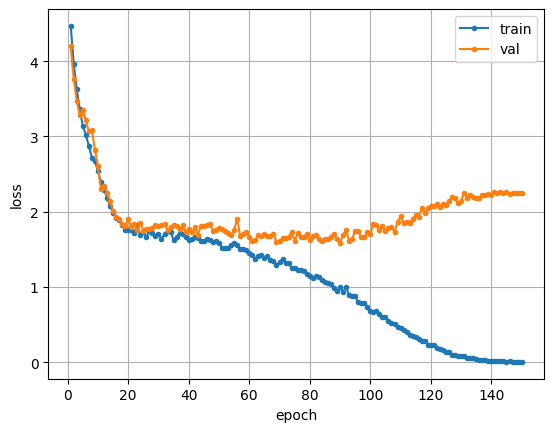

In [28]:
# グラフ描画用のFigureオブジェクトを作成
fig = plt.figure()
# Figureにサブプロット(1行1列の1つ目のプロット)を追加
ax = fig.add_subplot(111)
# x軸のデータをエポック数に基づいて作成（1からhistory['train loss']の長さまでの範囲）
xs = np.arange(1, len(history['train loss']) + 1)
# トレーニングデータの損失をプロット
ax.plot(xs, history['train loss'], '.-', label='train')
# バリデーションデータの損失をプロット
ax.plot(xs, history['val loss'], '.-', label='val')

ax.set_xlabel('epoch') # x軸のラベルを設定
ax.set_ylabel('loss') # y軸のラベルを設定
ax.legend() # 凡例を表示
ax.grid() # グリッドを表示
plt.show() # グラフを表示


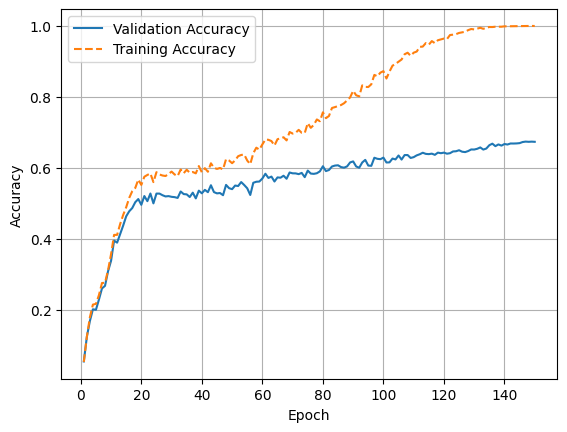

In [29]:
# グラフ描画用のFigureオブジェクトを作成
fig = plt.figure()
# Figureにサブプロット(1行1列の1つ目のプロット)を追加
ax = fig.add_subplot(111)
# x軸のデータをエポック数に基づいて作成（1からhistory['val acc']の長さまでの範囲）
xs = np.arange(1, len(history['val acc']) + 1)
# バリデーションデータの正解率をプロット
ax.plot(xs, history['val acc'], label='Validation Accuracy', linestyle='-')
# トレーニングデータの正解率をプロット
ax.plot(xs, history['train acc'], label='Training Accuracy', linestyle='--')
ax.set_xlabel('Epoch') # x軸のラベルを設定
ax.set_ylabel('Accuracy') # y軸のラベルを設定
ax.grid() # グリッドを表示
ax.legend()  # 凡例を追加
plt.show() # グラフを表示
